# Introduction

In this notebook, I will develop a system for forecasting influenza viral evolution. More specifically, I would like to predict the probability distribution over new influenza sequences, given current sequences.

## Use Case

This data product uses my background knowledge of influenza evolution and marries it with recent skills picked up in deep learning to try to forecast future influenza sequences. This is potentially a long-term competitive advantage for a company building out vaccines against fast-evolving viruses, and more generally, a long-term competitive advantage for public health.

Borrowing a quote from one of the great ice hockey players,

> I skate to where the puck will be, not where it has already been. (Wayne Gretzky)

## Data

The data come from the [influenza research database ](https://www.fludb.org/)(IRD). Search parameters were as follows:

- Data Type: Protein
- Virus Type: A
- Subtype: H3N2
- Date Range: From 2000
- 'Classical' Proteins: Complete? HA

No other search parameters were used. Data were downloaded on 31 May 2017.

## Learning Strategy

1. Use variational autoencoders, a deep learning method, to learn a latent manifold on which sequence evolution is taking place. 
1. Simultaneously construct a genotype network of flu evolution.
    1. Nodes: Influenza HA protein sequences.
    1. Edges: Sequences differ by one amino acid.
1. Sanity checks:
    1. Plot edit distance between any two random pairs of protein sequences against their manifold distance. There should be a linear relationship between the two.
1. Validation:
    1. MVP validation will be done by doing one round of "back testing" - we 
    
    
## Technical aspects demonstrated

1. Deep learning.
1. Basic time series analysis.
1. Genomics.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import networkx as nx
import tensorflow as tf
import pymc3 as pm

plt.style.use('fivethirtyeight')


from Bio import SeqIO
from copy import deepcopy
from datetime import datetime
from keras.layers import Input, Dense, Lambda, Dropout
from keras.models import Model, model_from_json
from keras import backend as K
from keras import objectives
from keras.callbacks import EarlyStopping

from Levenshtein import distance as levD
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from scipy.spatial import ConvexHull
from scipy.spatial.distance import euclidean as eucD

from custom import load_sequence_and_metadata, encode_array, save_model, get_density_interval

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

1 #define _CUDA_NDARRAY_C
2 
3 #include <Python.h>
4 #include <structmember.h>
5 #include "theano_mod_helper.h"
6 
7 #include <numpy/arrayobject.h>
8 #include <iostream>
9 
10 #include "cuda_ndarray.cuh"
11 
12 #ifndef CNMEM_DLLEXPORT
13 #define CNMEM_DLLEXPORT
14 #endif
15 
16 #include "cnmem.h"
17 #include "cnmem.cpp"
18 
19 //If true, when there is a gpu malloc or free error, we print the size of allocated memory on the device.
20 #define COMPUTE_GPU_MEM_USED 0
21 
22 //If true, we fill with NAN allocated device memory.
23 #define ALLOC_MEMSET 0
24 
25 //If true, we print out when we free a device pointer, uninitialize a
26 //CudaNdarray, or allocate a device pointer
27 #define PRINT_FREE_MALLOC 0
28 
29 //If true, we do error checking at the start of functions, to make sure there
30 //is not a pre-existing error when the function is called.
31 //You probably need to set the environment variable
32 //CUDA_LAUNCH_BLOCKING=1, and/or modify the CNDA_THREAD_SYNC
33 //preprocessor macro 

2108 PyObject *
2109 CudaNdarray_inplace_add(PyObject* py_self, PyObject * py_other)
2110 {
2111     if (CudaNdarray_inplace_elemwise(py_self, py_other, IADD))
2112     {
2113         return NULL;
2114     }
2115     Py_INCREF(py_self);
2116     return py_self;
2117 }
2118 
2119 /*
2120  * We need this inplace div for cuda/tests/test_basic_ops.py:test_shared_options
2121  * It returns py_self on success with an additional reference. Else NULL.
2122  */
2123 // Will be called by __idiv__ in Python
2124 static PyObject *
2125 CudaNdarray_inplace_div(PyObject* py_self, PyObject * py_other)
2126 {
2127     if (CudaNdarray_inplace_elemwise(py_self, py_other, IDIV))
2128     {
2129         return NULL;
2130     }
2131     Py_INCREF(py_self);
2132     return py_self;
2133 }
2134 
2135 // The PyNumberMethods struct layout changed in a non-trivial way from 2 to 3.
2136 #if PY_MAJOR_VERSION == 3
2137 static PyNumberMethods CudaNdarrayNumberMethods =
2138 {
2139     (binaryfunc)CudaNdarray_add,  

4670         }
4671         // now we've got pointers a_data_i and z_data_i into element 0 of the slice over which we are reducing
4672         // do a similar loop
4673 
4674         float sum = 0.0f;
4675         switch(n_reduce_dims)
4676         {
4677             case 0:
4678                 {
4679                     sum = a_data_i[0];
4680                 }
4681                 break;
4682             case 1:
4683                 {
4684                     const int stride = a_str[reduce_dim0];
4685                     const float * a_data_i_max = a_data_i + dims_a[reduce_dim0] * stride;
4686                     while (a_data_i != a_data_i_max)
4687                     {
4688                         sum += a_data_i[0];
4689                         a_data_i += stride;
4690                     }
4691                 }
4692                 break;
4693             case 2:
4694                 {
4695                     int rd = reduce_dim0+1;
4696                     for (; rd < nd;

ERROR (theano.gpuarray): pygpu was configured but could not be imported or is too old (version 0.6 or higher required)
NoneType: None



['nvcc', '-shared', '-O3', '-m64', '-Xcompiler', '-DCUDA_NDARRAY_CUH=mc72d035fdf91890f3b36710688069b2e,-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION,-fPIC,-fvisibility=hidden', '-Xlinker', '-rpath,/home/ericmjl/.theano/compiledir_Linux-4.8--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.1-64/cuda_ndarray', '-I/home/ericmjl/anaconda/envs/pymc3/lib/python3.6/site-packages/theano/sandbox/cuda', '-I/home/ericmjl/anaconda/envs/pymc3/lib/python3.6/site-packages/numpy/core/include', '-I/home/ericmjl/anaconda/envs/pymc3/include/python3.6m', '-I/home/ericmjl/anaconda/envs/pymc3/lib/python3.6/site-packages/theano/gof', '-L/home/ericmjl/anaconda/envs/pymc3/lib', '-o', '/home/ericmjl/.theano/compiledir_Linux-4.8--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.1-64/cuda_ndarray/cuda_ndarray.so', 'mod.cu', '-lcublas', '-lpython3.6m', '-lcudart']


Using TensorFlow backend.


In [2]:
from pymc3 import gp

We first will start with doing some basic cleaning of the data.

1. We want to make sure that there's only human flu sequences. The dataset may contain non-flu sequences.
1. We want to forecast 2017 sequences. Therefore, any machine learning fitting can only be done on the data up to 2016; any predictions are to be done on 2017 sequences.

In [3]:
# Let's start by loading the protein sequence FASTA file and metadata.
sequences, metadata = load_sequence_and_metadata()
assert len(sequences) == len(metadata)

# Filter for just human sequences, then split into training and test set.
metadata = metadata[metadata['Host Species'] == 'IRD:Human']
training_metadata = metadata[metadata['Collection Date'] < datetime(2017, 1, 1)]
training_idxs = [i for i, s in enumerate(sequences) if s.id in training_metadata['Sequence Accession'].values]

test_metadata = metadata[metadata['Collection Date'] >= datetime(2017, 1, 1)]
test_idxs = [i for i, s in enumerate(sequences) if s.id in test_metadata['Sequence Accession'].values]

# Encode as array.
sequence_array = encode_array(sequences)
training_array = sequence_array[training_idxs]
test_array = sequence_array[test_idxs]

training_sequences = [sequences[i] for i in training_idxs]
test_sequences = [sequences[i] for i in test_idxs]

In [4]:
# Sanity checks
assert len(training_array) == len(training_metadata)
assert len(test_array) == len(test_metadata)

Let's now build the variational autoencoder model. This is a deep learning model that provides us with a way to learn a latent representation of discrete sequence space as a continuous representation instead. It's both a visualization tool and a deep learning data compression tool.

In [5]:
# # Set up VAE.
# with tf.device('/gpu:0'):
#     intermediate_dim = 1000
#     encoding_dim = 3
#     latent_dim = encoding_dim
#     epsilon_std = 1.0
#     nb_epoch = 250

#     x = Input(shape=(training_array.shape[1],))
#     z_mean = Dense(latent_dim)(x)
#     z_log_var = Dense(latent_dim)(x)

#     def sampling(args):
#         z_mean, z_log_var = args
#         epsilon = K.random_normal(shape=(latent_dim, ), mean=0.,
#                                   stddev=epsilon_std)
#         return z_mean + K.exp(z_log_var / 2) * epsilon


#     def vae_loss(x, x_decoded_mean):
#         xent_loss = training_array.shape[1] * objectives.binary_crossentropy(x, x_decoded_mean)
#         kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
#         return xent_loss + kl_loss

#     z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
#     x_decoded_mean = Dense(training_array.shape[1], activation='sigmoid')(z_mean)

#     vae = Model(x, x_decoded_mean)
#     vae.compile(optimizer='adam', loss=vae_loss)

#     # build a model to project inputs on the latent space
#     encoder = Model(x, z_mean)
#     encoder_var = Model(x, z_log_var)

#     x_train, x_test = train_test_split(training_array)

#     early_stopping = EarlyStopping(monitor="val_loss", patience=2)


#     # build the decoder
#     encoded_input = Input(shape=(encoding_dim,))
#     # retrieve the last layer of the autoencoder model
#     decoder_layer = vae.layers[-1]
#     # create the decoder model
#     decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))


#     # Train the VAE to learn weights
#     vae.fit(x_train, x_train,
#             shuffle=True,
#             epochs=nb_epoch,
#             validation_data=(x_test, x_test),
#             callbacks=[early_stopping],
#            )

# Putting VAEs into Production

How might we put the VAE into production? Keras allows us to save and load models as `.h5` and `.json` files. (Reference [here](http://machinelearningmastery.com/save-load-keras-deep-learning-models/).)

I will save the model as it is right now under the `trained_models/` directory.

In [6]:
# save_model(vae, 'trained_models/vae')
# save_model(encoder, 'trained_models/encoder')
# save_model(decoder, 'trained_models/decoder')

In [7]:
# with open('trained_models/vae.yaml', 'r+') as f:
#     yaml_spec = f.read()

In [8]:
from custom import load_model
vae = load_model('trained_models/vae')
encoder = load_model('trained_models/encoder')
decoder = load_model('trained_models/decoder')

In [9]:
training_embeddings_mean = encoder.predict(training_array)
training_embeddings_mean.shape

(13373, 3)

Let's compute the convex hull of the `test_embedding` points, so that it can be laid over the `training_embedding` points.

In [10]:
test_embeddings_mean = encoder.predict(test_array)
test_embeddings_hull = ConvexHull(test_embeddings_mean)

In [11]:
lowp, highp = get_density_interval(99, training_embeddings_mean, axis=0)
lowp, highp

(array([-1.6280247 , -4.0219806 , -0.79145813]),
 array([ 3.00617099,  0.32198843,  3.30450177]))

In [12]:
# lowp, highp = get_density_interval(97.5, test_embeddings_mean, axis=0)
# lowp, highp

Let's visualize the latent space, which is currently encoded in 3 dimensions.

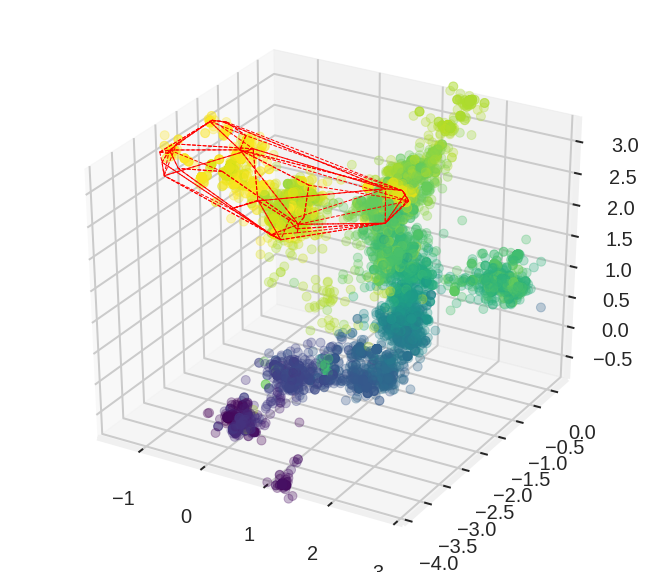

In [13]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(training_embeddings_mean[:, 0], 
           training_embeddings_mean[:, 1], 
           training_embeddings_mean[:, 2], 
           c=training_metadata['Collection Date'], cmap='viridis')
for simplex in test_embeddings_hull.simplices:
    ax.plot(test_embeddings_mean[simplex, 0], 
            test_embeddings_mean[simplex, 1], 
            test_embeddings_mean[simplex, 2], 'r--', lw=0.5)
ax.set_xlim(lowp[0], highp[0])
ax.set_ylim(lowp[1], highp[1])
ax.set_zlim(lowp[2], highp[2])
ax.set_facecolor('white')
plt.show()

Let's save the learned coordinates to disk, so that it can be visualized in a separate file. Uncomment the cell if new training happened, and the coordinates need to be updated.

In [14]:
# training_metadata.loc[:, ['coords0', 'coords1', 'coords2']] = training_embeddings_mean
# training_metadata.tail()
# training_metadata.to_csv('data/metadata_with_embeddings.csv')

# Sanity Check 1: Distances

I want to do a sanity check on the protein sequences. The goal here is to figure out whether short embedding euclidean distances roughly equals to short Levenshtein distances between sequences. I will sample 1000 pairs of sequences, compute their Levenshtein distance and their euclidean distances, and check that there is a linear relationship between the two.

In [15]:
# Generate pairs of random indices.
indices = np.random.randint(low=0, high=len(training_array), size=(1000, 2))
indices

array([[ 4494,  2881],
       [11996,  6285],
       [10172,  6822],
       ..., 
       [11640,  5840],
       [ 8201, 13204],
       [ 9901, 11861]])

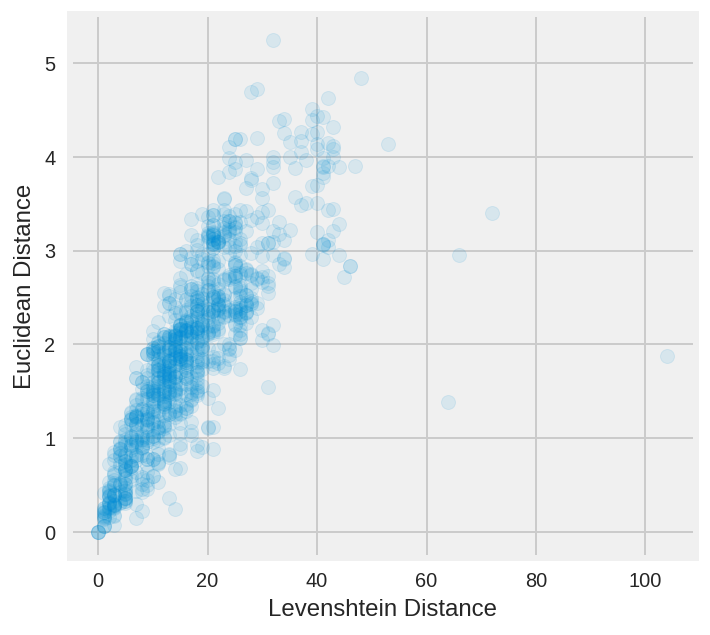

In [16]:
lev_dists = []
euc_dists = []
for i1, i2 in indices:
    lev_dist = levD(str(training_sequences[i1].seq), str(training_sequences[i2].seq))
    euc_dist = eucD(training_embeddings_mean[i1], training_embeddings_mean[i2])
    
    lev_dists.append(lev_dist)
    euc_dists.append(euc_dist)
    
fig = plt.figure(figsize=(5,5))
plt.scatter(lev_dists, euc_dists, alpha=0.1)
plt.xlabel('Levenshtein Distance')
plt.ylabel('Euclidean Distance')

## Sanity Check Conclusion
Regardless of what indices are sampled, we will generally get back a linear relationship between Euclidean and Levenshtein distances. I feel good about this sanity check.

## Visualize Evolutionary Trajectory over Time

I'm now going to try visualizing the evolutionary trajectory of the HA protein, day-by-day. We will take the average coordinate per day, and plot them in 3D space.

In [195]:
from ipywidgets import interact
from ipywidgets.widgets import Dropdown

tm_coords = deepcopy(training_metadata)  # tm_coords means "training metadata with coordinates"
tm_coords['coord0'] = training_embeddings_mean[:, 0]
tm_coords['coord1'] = training_embeddings_mean[:, 1]
tm_coords['coord2'] = training_embeddings_mean[:, 2]
avg_coords_by_day = tm_coords.groupby('Collection Date')\
                            [['coord0', 'coord1', 'coord2']].mean()\
                            .resample("D").mean().dropna().reset_index()

avg_coords_by_quarter = tm_coords.groupby('Collection Date')\
                            [['coord0', 'coord1', 'coord2']].mean().\
                            resample("Q").mean().dropna().reset_index()

        
# avg_coords_by_year = tm_coords.groupby('Collection Date')\
#                             [['coord0', 'coord1', 'coord2']].mean().\
#                             resample("Y").mean().dropna().reset_index()

@interact(elev=(-180, 180, 10), azim=(0, 360, 10))
def plot_daily_avg(elev, azim):

    fig = plt.figure(figsize=(16,8))
    ax1 = fig.add_subplot(1,2,1, projection='3d')
    ax1.scatter(xs=avg_coords_by_day['coord0'],
                ys=avg_coords_by_day['coord1'],
                zs=avg_coords_by_day['coord2'],
                c=avg_coords_by_day['Collection Date'], 
                cmap='viridis')
    ax1.view_init(elev, azim)
    ax1.set_title('by day')
    
    ax2 = fig.add_subplot(1,2,2, projection='3d')
    ax2.scatter(xs=avg_coords_by_quarter['coord0'], 
                ys=avg_coords_by_quarter['coord1'], 
                zs=avg_coords_by_quarter['coord2'], 
                c=avg_coords_by_quarter['Collection Date'], 
                cmap='viridis')
    ax2.view_init(elev=elev, azim=azim)
    ax2.set_title('by quarter')
    
    ax1.set_xlim(ax2.get_xlim())
    ax1.set_ylim(ax2.get_ylim())
    ax1.set_zlim(ax2.get_zlim())
    
    for simplex in test_embeddings_hull.simplices:
        ax1.plot(test_embeddings_mean[simplex, 0], 
                 test_embeddings_mean[simplex, 1], 
                 test_embeddings_mean[simplex, 2], 
                 'k--', lw=0.2)
        
    ax1.set_facecolor('white')
    ax2.set_facecolor('white')

    plt.show()


Looking at the data, it looks most feasible to try predicting coordinates for the coming **months**, particularly trying to go out 3-6 months.

Let's transform the 3D plots into three 1D plots. (This is just a viz aid.)

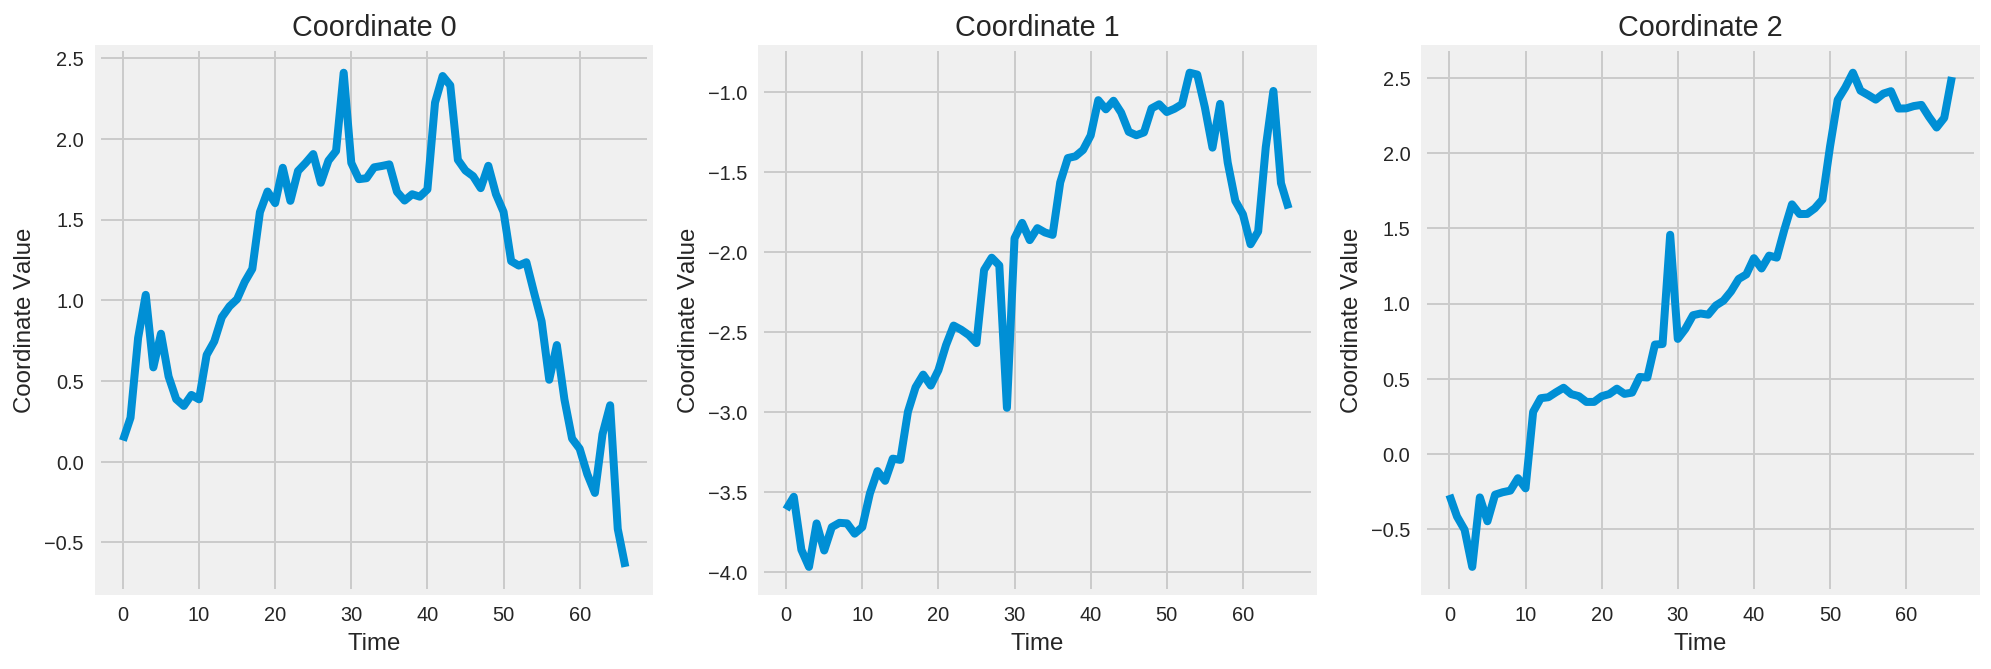

In [41]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1)
ax1.plot(avg_coords_by_quarter['coord0'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Coordinate Value')
ax1.set_title('Coordinate 0')

ax2 = fig.add_subplot(1,3,2)
ax2.plot(avg_coords_by_quarter['coord1'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Coordinate Value')
ax2.set_title('Coordinate 1')

ax3 = fig.add_subplot(1,3,3)
ax3.plot(avg_coords_by_quarter['coord2'])
ax3.set_xlabel('Time')
ax3.set_ylabel('Coordinate Value')
ax3.set_title('Coordinate 2')
plt.show()

# GP for Timeseries

Here's me trying out GPs for time series. I've hacked this once before, following an example, so maybe it's transferrable...

In [132]:
import theano.tensor as tt

def build_coords_model(coordinate):
    y_vals = avg_coords_by_quarter[coordinate].values.astype('float32')
    x_vals = np.array(range(len(avg_coords_by_quarter))).reshape(-1, 1).astype('float32')
    print(x_vals.shape, y_vals.shape)

    with pm.Model() as model:
        # l = pm.HalfCauchy('l', beta=20)
        l = pm.Uniform('l', 0, 30)

        # Covariance function
        log_s2_f = pm.Uniform('log_s2_f', lower=-10, upper=5)
        s2_f = pm.Deterministic('s2_f', tt.exp(log_s2_f))
        # s2_f = pm.HalfCauchy('s2_f', beta=2)
        # f_cov = s2_f * pm.gp.cov.Matern52(input_dim=1, lengthscales=l)
        f_cov = s2_f * pm.gp.cov.ExpQuad(input_dim=1, lengthscales=l)

        # Sigma
        log_s2_n = pm.Uniform('log_s2_n', lower=-10, upper=5)
        s2_n = pm.Deterministic('s2_n', tt.exp(log_s2_n))
        # s2_n = pm.HalfCauchy('s2_n', beta=2)

        y_obs = pm.gp.GP('y_obs', cov_func=f_cov, sigma=s2_n, 
                         observed={'X':x_vals, 
                                   'Y':y_vals})
        trace = pm.sample(2000)

        pp_x = np.arange(len(avg_coords_by_quarter)+2)[:, None]
        gp_samples = pm.gp.sample_gp(trace=trace, gp=y_obs, X_values=pp_x, samples=1000)

    return gp_samples

In [133]:
coord0_preds = build_coords_model('coord0')

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


(67, 1) (67,)


Average ELBO = -16.522: 100%|██████████| 200000/200000 [02:44<00:00, 1217.70it/s]
Finished [100%]: Average ELBO = -16.509
  0%|          | 0/1000 [00:00<?, ?it/s]/home/ericmjl/anaconda/envs/pymc3/lib/python3.6/site-packages/scipy/stats/_multivariate.py:535: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
100%|██████████| 1000/1000 [00:23<00:00, 42.22it/s]


In [134]:
coord1_preds = build_coords_model('coord1')

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


(67, 1) (67,)


Average ELBO = -14.607: 100%|██████████| 200000/200000 [02:48<00:00, 1184.61it/s]
Finished [100%]: Average ELBO = -14.622
  0%|          | 0/1000 [00:00<?, ?it/s]/home/ericmjl/anaconda/envs/pymc3/lib/python3.6/site-packages/scipy/stats/_multivariate.py:535: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
100%|██████████| 1000/1000 [00:24<00:00, 40.95it/s]


In [135]:
coord2_preds = build_coords_model('coord2')

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


(67, 1) (67,)


Average ELBO = 2.677: 100%|██████████| 200000/200000 [02:48<00:00, 1189.25it/s] 
Finished [100%]: Average ELBO = 2.6794
Evidence of divergence detected, inspect ELBO.
  0%|          | 0/1000 [00:00<?, ?it/s]/home/ericmjl/anaconda/envs/pymc3/lib/python3.6/site-packages/scipy/stats/_multivariate.py:535: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
100%|██████████| 1000/1000 [00:24<00:00, 40.69it/s]


In [136]:
coord0_preds.shape, coord1_preds.shape, coord2_preds.shape, 

((1000, 69), (1000, 69), (1000, 69))

I'm now going to 

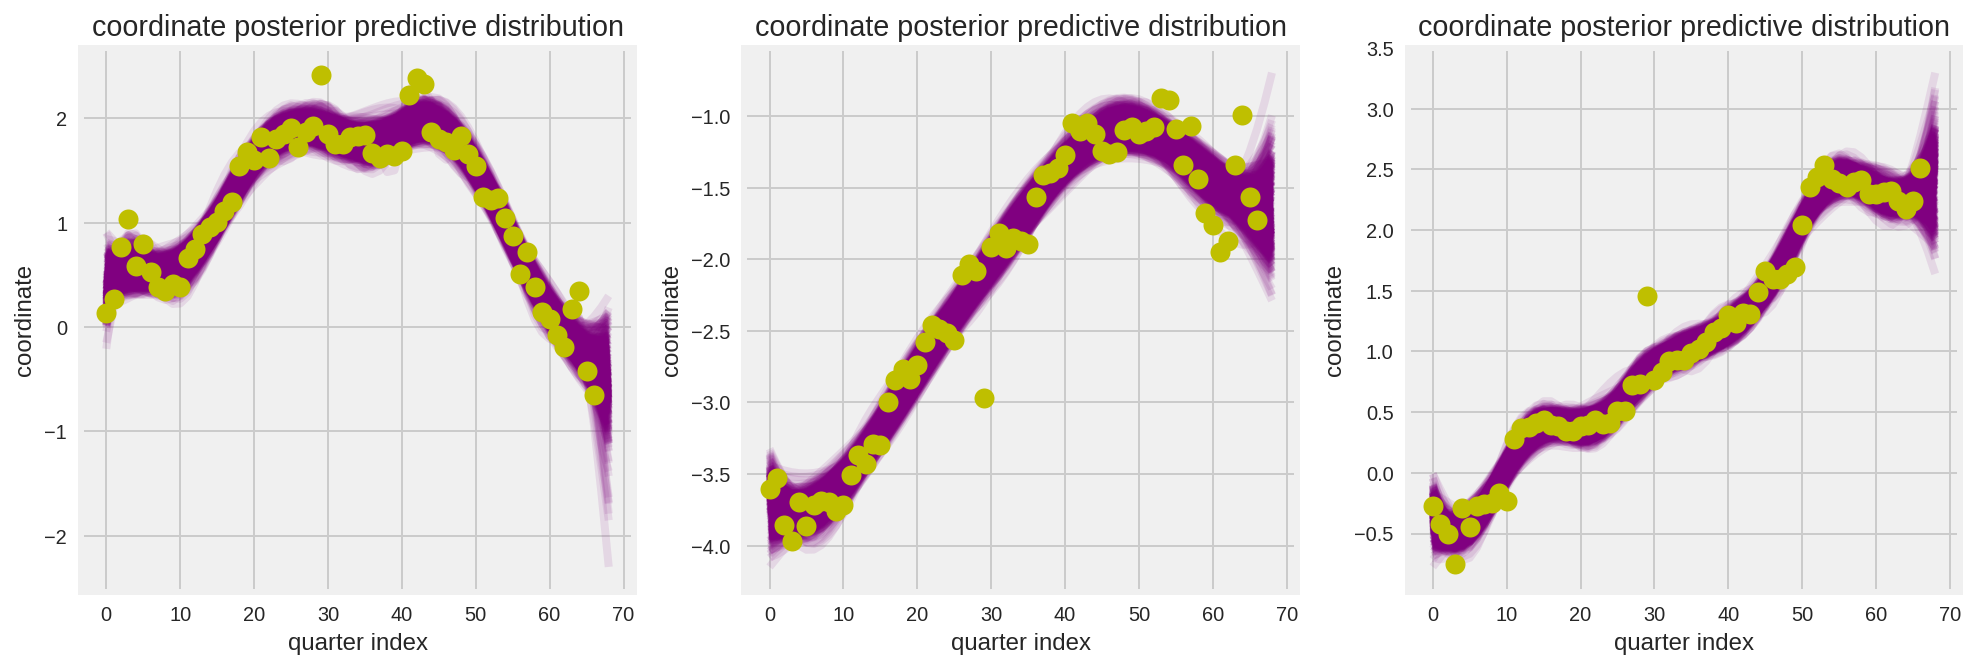

In [166]:
def plot_coords_with_groundtruth(coord_preds, data, ax):

    for x in coord_preds:
        ax.plot(pp_x, x, color='purple', alpha=0.1)
    ax.plot(x_vals, data, 'oy', ms=10);
    ax.set_xlabel("quarter index");
    ax.set_ylabel("coordinate");
    ax.set_title("coordinate posterior predictive distribution");
    
    return ax

fig = plt.figure(figsize=(15,5))
ax0 = fig.add_subplot(1,3,1)
ax1 = fig.add_subplot(1,3,2)
ax2 = fig.add_subplot(1,3,3)
plot_coords_with_groundtruth(coord0_preds, avg_coords_by_quarter['coord0'], ax0)
plot_coords_with_groundtruth(coord1_preds, avg_coords_by_quarter['coord1'], ax1)
plot_coords_with_groundtruth(coord2_preds, avg_coords_by_quarter['coord2'], ax2)


In [193]:
one_quarter_pred = np.array([coord0_preds[:, -2], coord1_preds[:, -2], coord2_preds[:, -2]]).T
two_quarter_pred = np.array([coord0_preds[:, -1], coord1_preds[:, -1], coord2_preds[:, -1]]).T

# Grab out the 95% HPD interval from the data, filter out the data that are outside of HPD
oneQ_low, oneQ_high = get_density_interval(95, one_quarter_pred)
oneQ_low, oneQ_high

(array([-0.79457096, -1.94487804,  2.04799729]),
 array([-0.05010806, -1.33629535,  2.66937914]))

In [157]:
test_embeddings_mean

array([[-0.16917507, -1.47612083,  1.75800097],
       [-0.8223381 , -1.67774343,  3.00160122],
       [-0.93456453, -1.85243511,  2.42643428],
       ..., 
       [-1.53378665, -2.12063313,  2.74607778],
       [-1.21032155, -2.20410991,  2.56491613],
       [-1.53378665, -2.12063313,  2.74607778]], dtype=float32)

In [187]:
test_coords_embed = deepcopy(test_metadata)
test_coords_embed['coord0'] = test_embeddings_mean[:, 0]
test_coords_embed['coord1'] = test_embeddings_mean[:, 1]
test_coords_embed['coord2'] = test_embeddings_mean[:, 2]
test_coords_embed = test_coords_embed.set_index('Collection Date').resample('Q').mean().reset_index()
test_coords_embed

,Collection Date,Segment,Segment Length,Unnamed: 12,coord0,coord1,coord2
0,2017-03-31,4.0,1734.832853,NaN,-0.700494,-1.664800,2.457307
1,2017-06-30,4.0,1737.000000,NaN,-0.536831,-1.530502,2.380945


Compute the convex hull of the scatter points, and check to see whether the 2017 two quarters are within the predicted convex hull.

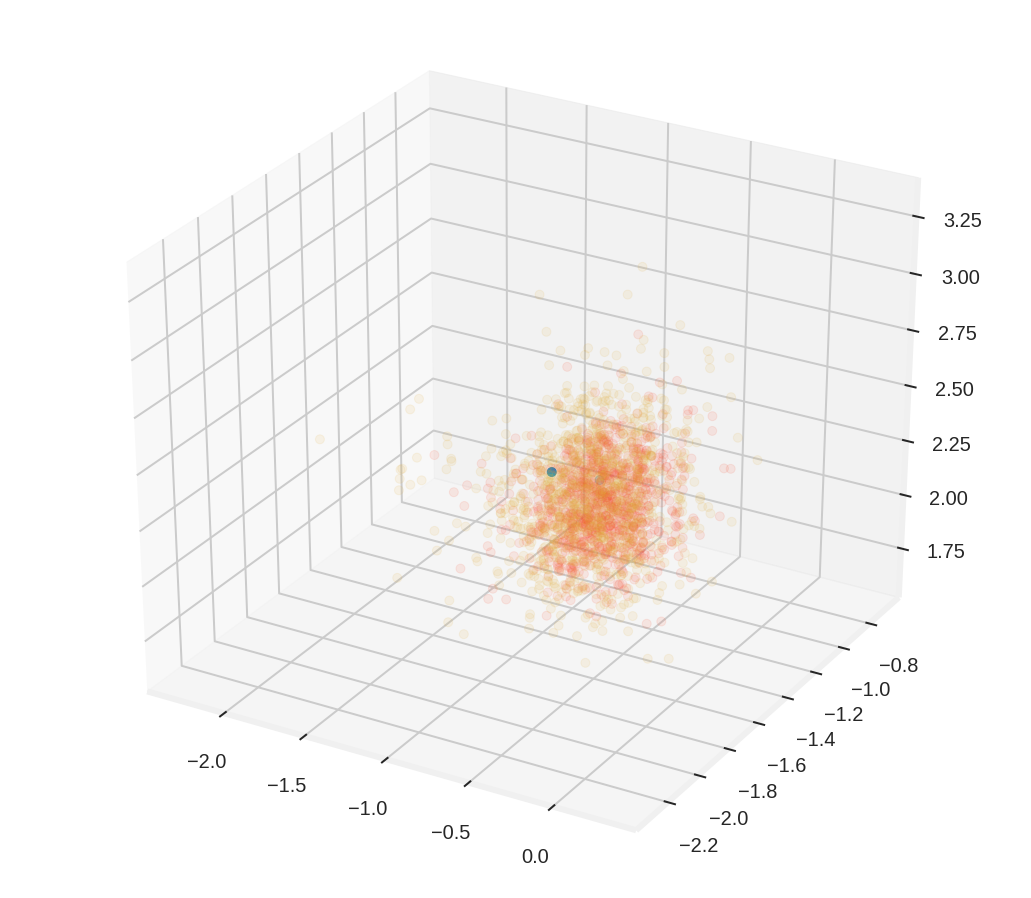

In [192]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(test_coords_embed['coord0'], test_coords_embed['coord1'], 
           test_coords_embed['coord2'], s=20,)
ax.scatter(one_quarter_pred[:, 0], one_quarter_pred[:, 1], one_quarter_pred[:, 2], alpha=0.1)
ax.scatter(two_quarter_pred[:, 0], two_quarter_pred[:, 1], two_quarter_pred[:, 2], alpha=0.1)
ax.set_facecolor('white')